# 第十二周作业参考

## 参考一 2019200886+管若昕

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import log,exp
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from numpy import inf
import copy
import operator
import math
import random as rd

# 第一题

西瓜书8.3 Adaboosting

### Code

In [94]:
labels = ['密度','含糖率']
data = [
    [0.697,0.46,'是'],
    [0.774,0.376,'是'],
    [0.634,0.264,'是'],
    [0.608,0.318,'是'],
    [0.556,0.215,'是'],
    [0.403,0.237,'是'],
    [0.481,0.149,'是'],
    [0.437,0.211,'是'],
    [0.666,0.091,'否'],
    [0.243,0.267,'否'],
    [0.245,0.057,'否'],
    [0.343,0.099,'否'],
    [0.639,0.161,'否'],
    [0.657,0.198,'否'],
    [0.36,0.37,'否'],
    [0.593,0.042,'否'],
    [0.719,0.103,'否']
]


In [95]:
### AdaBoost
def loadata(data, D):    #重塑data以用于分类
    redata = []
    dc = copy.deepcopy(data)
    for i in range(len(data)):
        dc[i].insert(-1,D[i])
        redata.append(dc[i])
    return redata

def errorate(clf, d, D, classList, labels, labelproperties):     #计算误差率函数 clf：生成的决策树
    pred = [reclassify(classify(clf, classList, labels, labelproperties, featvec)) for featvec in d] #模型预测结果
    #计算误差率
    eind = []
    error = 0
    for i in range(len(pred)):
        if d[i][-1] != pred[i]:
            eind.append(i)
            error += D[i]
    return error, eind             #误差率，判错数据的序数

def reD(clf, data, D, error, eind):   #更新权值函数
    #修改正确识别和错误识别的样本的权重
    a = log((1-error)/error)
    z = 2*(error*(1-error))**0.5    #规范化因子
    reD = [i*exp(a)/z if D.index(i) in eind else i*exp(-a)/z for i in D]    #修改权值
    return a, reD

def adaboost(T, data, classList, labels, labelproperties):   #训练轮数，数据，数据特征等
    alphas = []   #存储权重们
    trees = []    #存储分类器们
    D = [1/17]*17     #初始化样本平均权重
    for _ in range(T):
        dataSet = loadata(data, D)
        tree = createTree(dataSet, labels, labelProperties)
        error, eind = errorate(tree,  dataSet, D, classList, labels, labelproperties)
        a, D = reD(tree, dataSet, D, error, eind)
        alphas.append(a)
        trees.append(tree)
    return alphas, trees

In [86]:
### Decision Tree
# 计算信息熵
def calcShannonEnt(dataSet, labelIndex):
    # type: (list) -> float
    numEntries = 0  # 样本数(按权重计算）
    labelCounts = {}
    for featVec in dataSet:  # 遍历每个样本
        if featVec[labelIndex] != 'N':
            weight = float(featVec[-2])
            numEntries += weight
            currentLabel = featVec[-1]  # 当前样本的类别
            if currentLabel not in labelCounts.keys():  # 生成类别字典
                labelCounts[currentLabel] = 0
            labelCounts[currentLabel] += weight  # 数据集的倒数第二个值用来标记样本权重
    shannonEnt = 0.0
    for key in labelCounts:  # 计算信息熵
        prob = float(labelCounts[key]) / numEntries
        shannonEnt = shannonEnt - prob * log(prob, 2)
    return shannonEnt


def splitDataSet(dataSet, axis, value, LorR='N'):
    """
    type: (list, int, string or float, string) -> list
    划分数据集
    axis:按第几个特征划分
    value:划分特征的值
    LorR: N 离散属性; L 小于等于value值; R 大于value值
    """
    retDataSet = []
    featVec = []
    if LorR == 'N':  # 离散属性
        for featVec in dataSet:
            if featVec[axis] == value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec.extend(featVec[axis + 1:])
                retDataSet.append(reducedFeatVec)
    elif LorR == 'L':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) < value:
                    retDataSet.append(featVec)
    elif LorR == 'R':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) > value:
                    retDataSet.append(featVec)
    return retDataSet


def splitDataSetWithNull(dataSet, axis, value, LorR='N'):
    """
    type: (list, int, string or float, string) -> list
    划分数据集
    axis:按第几个特征划分
    value:划分特征的值
    LorR: N 离散属性; L 小于等于value值; R 大于value值
    """
    retDataSet = []
    nullDataSet = []
    featVec = []
    totalWeightV = calcTotalWeight(dataSet, axis, False)  # 非空样本权重
    totalWeightSub = 0.0
    if LorR == 'N':  # 离散属性
        for featVec in dataSet:
            if featVec[axis] == value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec.extend(featVec[axis + 1:])
                retDataSet.append(reducedFeatVec)
            elif featVec[axis] == 'N':
                reducedNullVec = featVec[:axis]
                reducedNullVec.extend(featVec[axis + 1:])
                nullDataSet.append(reducedNullVec)
    elif LorR == 'L':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) < value:
                    retDataSet.append(featVec)
            elif featVec[axis] == 'N':
                nullDataSet.append(featVec)
    elif LorR == 'R':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) > value:
                    retDataSet.append(featVec)
            elif featVec[axis] == 'N':
                nullDataSet.append(featVec)

    totalWeightSub = calcTotalWeight(retDataSet, -1, True)  # 计算此分支中非空样本的总权重
    for nullVec in nullDataSet:  # 把缺失值样本按权值比例划分到分支中
        nullVec[-2] = float(nullVec[-2]) * totalWeightSub / totalWeightV
        retDataSet.append(nullVec)

    return retDataSet


def calcTotalWeight(dataSet, labelIndex, isContainNull):
    """
    type: (list, int, bool) -> float
    计算样本集对某个特征值的总样本树（按权重计算）
    :param dataSet: 数据集
    :param labelIndex: 特征值索引
    :param isContainNull: 是否包含空值的样本
    :return: 返回样本集的总权重值
    """
    totalWeight = 0.0
    for featVec in dataSet:  # 遍历每个样本
        weight = float(featVec[-2])
        if isContainNull is False and featVec[labelIndex] != 'N':
            totalWeight += weight  # 非空样本树，按权重计算
        if isContainNull is True:
            totalWeight += weight  # 总样本数，按权重计算
    return totalWeight


def calcGain(dataSet, labelIndex, labelPropertyi):
    """
    type: (list, int, int) -> float, int
    计算信息增益,返回信息增益值和连续属性的划分点
    dataSet: 数据集
    labelIndex: 特征值索引
    labelPropertyi: 特征值类型，0为离散，1为连续
    """
    baseEntropy = calcShannonEnt(dataSet, labelIndex)  # 计算根节点的信息熵
    featList = [example[labelIndex] for example in dataSet]  # 特征值列表
    uniqueVals = set(featList)  # 该特征包含的所有值
    newEntropy = 0.0
    totalWeight = 0.0
    totalWeightV = 0.0
    totalWeight = calcTotalWeight(dataSet, labelIndex, True)  # 总样本权重
    totalWeightV = calcTotalWeight(dataSet, labelIndex, False)  # 非空样本权重
    if labelPropertyi == 0:  # 对离散的特征
        for value in uniqueVals:  # 对每个特征值，划分数据集, 计算各子集的信息熵
            if value != 'N':
                subDataSet = splitDataSet(dataSet, labelIndex, value)
                totalWeightSub = 0.0
                totalWeightSub = calcTotalWeight(subDataSet, labelIndex, True)
                prob = totalWeightSub / totalWeightV
                newEntropy += prob * calcShannonEnt(subDataSet, labelIndex)
    else:  # 对连续的特征
        uniqueValsList = list(uniqueVals)
        if 'N' in uniqueValsList:
            uniqueValsList.remove('N')
        sortedUniqueVals = sorted(uniqueValsList)  # 对特征值排序
        listPartition = []
        minEntropy = inf
        if len(sortedUniqueVals) == 1:  # 如果只有一个值，可以看作只有左子集，没有右子集
            totalWeightLeft = calcTotalWeight(dataSet, labelIndex, True)
            probLeft = totalWeightLeft / totalWeightV
            minEntropy = probLeft * calcShannonEnt(dataSet, labelIndex)
        else:
            for j in range(len(sortedUniqueVals) - 1):  # 计算划分点
                partValue = (float(sortedUniqueVals[j]) + float(
                    sortedUniqueVals[j + 1])) / 2
                # 对每个划分点，计算信息熵
                dataSetLeft = splitDataSet(dataSet, labelIndex, partValue, 'L')
                dataSetRight = splitDataSet(dataSet, labelIndex, partValue, 'R')
                totalWeightLeft = 0.0
                totalWeightLeft = calcTotalWeight(dataSetLeft, labelIndex, True)
                totalWeightRight = 0.0
                totalWeightRight = calcTotalWeight(dataSetRight, labelIndex, True)
                probLeft = totalWeightLeft / totalWeightV
                probRight = totalWeightRight / totalWeightV
                Entropy = probLeft * calcShannonEnt(dataSetLeft, labelIndex) + \
                          probRight * calcShannonEnt(dataSetRight, labelIndex)
                if Entropy < minEntropy:  # 取最小的信息熵
                    minEntropy = Entropy
        newEntropy = minEntropy
    gain = totalWeightV / totalWeight * (baseEntropy - newEntropy)
    return gain


def calcGainRatio(dataSet, labelIndex, labelPropertyi):
    """
    type: (list, int, int) -> float, int
    计算信息增益率,返回信息增益率和连续属性的划分点
    dataSet: 数据集
    labelIndex: 特征值索引
    labelPropertyi: 特征值类型，0为离散，1为连续
    """
    baseEntropy = calcShannonEnt(dataSet, labelIndex)  # 计算根节点的信息熵
    featList = [example[labelIndex] for example in dataSet]  # 特征值列表
    uniqueVals = set(featList)  # 该特征包含的所有值
    newEntropy = 0.0
    bestPartValuei = None
    IV = 0.0
    totalWeight = 0.0
    totalWeightV = 0.0
    totalWeight = calcTotalWeight(dataSet, labelIndex, True)  # 总样本权重
    totalWeightV = calcTotalWeight(dataSet, labelIndex, False)  # 非空样本权重
    if labelPropertyi == 0:  # 对离散的特征
        for value in uniqueVals:  # 对每个特征值，划分数据集, 计算各子集的信息熵
            subDataSet = splitDataSet(dataSet, labelIndex, value)
            totalWeightSub = 0.0
            totalWeightSub = calcTotalWeight(subDataSet, labelIndex, True)
            if value != 'N':
                prob = totalWeightSub / totalWeightV
                newEntropy += prob * calcShannonEnt(subDataSet, labelIndex)
            prob1 = totalWeightSub / totalWeight
            IV -= prob1 * log(prob1, 2)
    else:  # 对连续的特征
        uniqueValsList = list(uniqueVals)
        if 'N' in uniqueValsList:
            uniqueValsList.remove('N')
            # 计算空值样本的总权重，用于计算IV
            totalWeightN = 0.0
            dataSetNull = splitDataSet(dataSet, labelIndex, 'N')
            totalWeightN = calcTotalWeight(dataSetNull, labelIndex, True)
            probNull = totalWeightN / totalWeight
            if probNull > 0.0:
                IV += -1 * probNull * log(probNull, 2)

        sortedUniqueVals = sorted(uniqueValsList)  # 对特征值排序
        listPartition = []
        minEntropy = inf

        if len(sortedUniqueVals) == 1:  # 如果只有一个值，可以看作只有左子集，没有右子集
            totalWeightLeft = calcTotalWeight(dataSet, labelIndex, True)
            probLeft = totalWeightLeft / totalWeightV
            minEntropy = probLeft * calcShannonEnt(dataSet, labelIndex)
            IV = -1 * probLeft * log(probLeft, 2)
        else:
            for j in range(len(sortedUniqueVals) - 1):  # 计算划分点
                partValue = (float(sortedUniqueVals[j]) + float(
                    sortedUniqueVals[j + 1])) / 2
                # 对每个划分点，计算信息熵
                dataSetLeft = splitDataSet(dataSet, labelIndex, partValue, 'L')
                dataSetRight = splitDataSet(dataSet, labelIndex, partValue, 'R')
                totalWeightLeft = 0.0
                totalWeightLeft = calcTotalWeight(dataSetLeft, labelIndex, True)
                totalWeightRight = 0.0
                totalWeightRight = calcTotalWeight(dataSetRight, labelIndex, True)
                probLeft = totalWeightLeft / totalWeightV
                probRight = totalWeightRight / totalWeightV
                Entropy = probLeft * calcShannonEnt(
                    dataSetLeft, labelIndex) + probRight * calcShannonEnt(dataSetRight, labelIndex)
                if Entropy < minEntropy:  # 取最小的信息熵
                    minEntropy = Entropy
                    bestPartValuei = partValue
                    probLeft1 = totalWeightLeft / totalWeight
                    probRight1 = totalWeightRight / totalWeight
                    IV += -1 * (probLeft1 * log(probLeft1, 2) + probRight1 * log(probRight1, 2))

        newEntropy = minEntropy
    gain = totalWeightV / totalWeight * (baseEntropy - newEntropy)
    if IV == 0.0:  # 如果属性只有一个值，IV为0，为避免除数为0，给个很小的值
        IV = 0.0000000001
    gainRatio = gain / IV
    return gainRatio, bestPartValuei


# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet, labelProperty):
    """
    type: (list, int) -> int, float
    :param dataSet: 样本集
    :param labelProperty: 特征值类型，1 连续， 0 离散
    :return: 最佳划分属性的索引和连续属性的划分值
    """
    numFeatures = len(labelProperty)  # 特征数
    bestInfoGainRatio = 0.0
    bestFeature = -1
    bestPartValue = None  # 连续的特征值，最佳划分值
    gainSum = 0.0
    gainAvg = 0.0
    for i in range(numFeatures):  # 对每个特征循环
        infoGain = calcGain(dataSet, i, labelProperty[i])
        gainSum += infoGain
    gainAvg = gainSum / numFeatures
    for i in range(numFeatures):  # 对每个特征循环
        infoGainRatio, bestPartValuei = calcGainRatio(dataSet, i, labelProperty[i])
        infoGain = calcGain(dataSet, i, labelProperty[i])
        if infoGainRatio > bestInfoGainRatio and infoGain > gainAvg:  # 取信息增益高于平均增益且信息增益率最大的特征
            bestInfoGainRatio = infoGainRatio
            bestFeature = i
            bestPartValue = bestPartValuei
    return bestFeature, bestPartValue


# 通过排序返回出现次数最多的类别
def majorityCnt(classList, weightList):
    classCount = {}
    for i in range(len(classList)):
        if classList[i] not in classCount.keys():
            classCount[classList[i]] = 0.0
        classCount[classList[i]] += round(float(weightList[i]),1)

    # python 2.7
    # sortedClassCount = sorted(classCount.iteritems(),
    #                         key=operator.itemgetter(1), reverse=True)
    sortedClassCount = sorted(classCount.items(),
                              key=operator.itemgetter(1), reverse=True)
    if len(sortedClassCount) == 1:
        return (sortedClassCount[0][0],sortedClassCount[0][1],0.0)
    return (sortedClassCount[0][0], sortedClassCount[0][1], sortedClassCount[1][1])


# 创建树, 样本集 特征 特征属性（0 离散， 1 连续）
def createTree(dataSet, labels, labelProperty):
    classList = [example[-1] for example in dataSet]  # 类别向量
    weightList = [example[-2] for example in dataSet]  # 权重向量
    
    if classList.count(classList[0]) == len(classList):  # 如果只有一个类别，返回
        totalWeiht = calcTotalWeight(dataSet,0,True)
        return (classList[0], round(totalWeiht,1),0.0)
    
    if len(dataSet[0]) == 1:  # 如果所有特征都被遍历完了，返回出现次数最多的类别
        return majorityCnt(classList,weightList)
    
    bestFeat, bestPartValue = chooseBestFeatureToSplit(dataSet,
                                                       labelProperty)  # 最优分类特征的索引
    if bestFeat == -1:  # 如果无法选出最优分类特征，返回出现次数最多的类别
        return majorityCnt(classList, weightList)
    if labelProperty[bestFeat] == 0:  # 对离散的特征
        bestFeatLabel = labels[bestFeat]
        myTree = {bestFeatLabel: {}}
        labelsNew = copy.copy(labels)
        labelPropertyNew = copy.copy(labelProperty)
        del (labelsNew[bestFeat])  # 已经选择的特征不再参与分类
        del (labelPropertyNew[bestFeat])
        featValues = [example[bestFeat] for example in dataSet]
        uniqueValue = set(featValues)  # 该特征包含的所有值
        uniqueValue.discard('N')
        for value in uniqueValue:  # 对每个特征值，递归构建树
            subLabels = labelsNew[:]
            subLabelProperty = labelPropertyNew[:]
            myTree[bestFeatLabel][value] = createTree(
                splitDataSetWithNull(dataSet, bestFeat, value), subLabels,
                subLabelProperty)
    elif labelProperty[bestFeat] == 1:  # 对连续的特征，不删除该特征，分别构建左子树和右子树
        bestFeatLabel = labels[bestFeat] + '<' + str(bestPartValue)
        myTree = {bestFeatLabel: {}}
        subLabels = labels[:]
        subLabelProperty = labelProperty[:]
        # 构建左子树
        valueLeft = 'Y'
        myTree[bestFeatLabel][valueLeft] = createTree(
            splitDataSetWithNull(dataSet, bestFeat, bestPartValue, 'L'), subLabels,
            subLabelProperty)
        # 构建右子树
        valueRight = 'N'
        myTree[bestFeatLabel][valueRight] = createTree(
            splitDataSetWithNull(dataSet, bestFeat, bestPartValue, 'R'), subLabels,
            subLabelProperty)
    return myTree

def classify(inputTree, classList, featLabels, featLabelProperties, testVec):
    firstStr = list(inputTree.keys())[0]  # 根节点
    firstLabel = firstStr
    lessIndex = str(firstStr).find('<')
    if lessIndex > -1:  # 如果是连续型的特征
        firstLabel = str(firstStr)[:lessIndex]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstLabel)  # 跟节点对应的特征
    classLabel = {}
    for classI in classList:
        classLabel[classI] = 0.0
    for key in secondDict.keys():  # 对每个分支循环
        if featLabelProperties[featIndex] == 0:  # 离散的特征
            if testVec[featIndex] == key:  # 测试样本进入某个分支
                if type(secondDict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    classLabelSub = classify(secondDict[key], classList, featLabels,
                                          featLabelProperties, testVec)
                    for classKey in classLabel.keys():
                        classLabel[classKey] += classLabelSub[classKey]
                else:  # 如果是叶子， 返回结果
                    for classKey in classLabel.keys():
                        if classKey == secondDict[key][0]:
                            classLabel[classKey] += secondDict[key][1]
                        else:
                            classLabel[classKey] += secondDict[key][2]
            elif testVec[featIndex] == 'N':  # 如果测试样本的属性值缺失，则进入每个分支
                if type(secondDict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    classLabelSub = classify(secondDict[key], classList, featLabels,
                                          featLabelProperties, testVec)
                    for classKey in classLabel.keys():
                        classLabel[classKey] += classLabelSub[key]
                else:  # 如果是叶子， 返回结果
                    for classKey in classLabel.keys():
                        if classKey == secondDict[key][0]:
                            classLabel[classKey] += secondDict[key][1]
                        else:
                            classLabel[classKey] += secondDict[key][2]
        else:
            partValue = float(str(firstStr)[lessIndex + 1:])
            if testVec[featIndex] == 'N':  # 如果测试样本的属性值缺失，则对每个分支的结果加和
                # 进入左子树
                if type(secondDict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    classLabelSub = classify(secondDict[key], classList, featLabels,
                                          featLabelProperties, testVec)
                    for classKey in classLabel.keys():
                        classLabel[classKey] += classLabelSub[classKey]
                else:  # 如果是叶子， 返回结果
                    for classKey in classLabel.keys():
                        if classKey == secondDict[key][0]:
                            classLabel[classKey] += secondDict[key][1]
                        else:
                            classLabel[classKey] += secondDict[key][2]
            elif float(testVec[featIndex]) <= partValue and key == 'Y':  # 进入左子树
                if type(secondDict['Y']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    classLabelSub = classify(secondDict['Y'], classList, featLabels,
                                             featLabelProperties, testVec)
                    for classKey in classLabel.keys():
                        classLabel[classKey] += classLabelSub[classKey]
                else:  # 如果是叶子， 返回结果
                    for classKey in classLabel.keys():
                        if classKey == secondDict[key][0]:
                            classLabel[classKey] += secondDict['Y'][1]
                        else:
                            classLabel[classKey] += secondDict['Y'][2]
            elif float(testVec[featIndex]) > partValue and key == 'N':
                if type(secondDict['N']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    classLabelSub = classify(secondDict['N'], classList, featLabels,
                                             featLabelProperties, testVec)
                    for classKey in classLabel.keys():
                        classLabel[classKey] += classLabelSub[classKey]
                else:  # 如果是叶子， 返回结果
                    for classKey in classLabel.keys():
                        if classKey == secondDict[key][0]:
                            classLabel[classKey] += secondDict['N'][1]
                        else:
                            classLabel[classKey] += secondDict['N'][2]
    
    return classLabel

def reclassify(classLabel):
    maxWeight = 0.0
    Label = ''
    for item in classLabel.items():
        if item[1] > maxWeight:
            Label = item[0]
    return Label

In [98]:
classList = ['是', '否']
labelProperties = [1, 1]
for i in [3, 5, 11]:
    a, t = adaboost(i, data, classList, labels, labelProperties)
    answer = '使用{}个分类器时：'
    print(answer.format(i))
    for _ in range(len(a)):
        answer = '第{}个分类器为{}，其权重为{}'
        print(answer.format(_+1,t[_],a[_]))
        print('\n')

使用3个分类器时：
第1个分类器为{'含糖率<0.126': {'Y': ('否', 0.3, 0.0), 'N': {'密度<0.3815': {'Y': ('否', 0.1, 0.0), 'N': {'含糖率<0.20450000000000002': {'Y': ('否', 0.2, 0.1), 'N': ('是', 0.4, 0.0)}}}}}}，其权重为2.772588722239781


第2个分类器为{'含糖率<0.126': {'Y': ('否', 0.0, 0.0), 'N': {'密度<0.3815': {'Y': ('否', 0.0, 0.0), 'N': {'含糖率<0.20450000000000002': {'Y': ('是', 0.0, 0.0), 'N': ('是', 0.1, 0.0)}}}}}}，其权重为2.468099531471619


第3个分类器为{'含糖率<0.126': {'Y': ('否', 0.0, 0.0), 'N': {'密度<0.3815': {'Y': ('否', 0.0, 0.0), 'N': {'含糖率<0.20450000000000002': {'Y': ('是', 0.0, 0.0), 'N': ('是', 0.0, 0.0)}}}}}}，其权重为3.8434753573709117


使用5个分类器时：
第1个分类器为{'含糖率<0.126': {'Y': ('否', 0.3, 0.0), 'N': {'密度<0.3815': {'Y': ('否', 0.1, 0.0), 'N': {'含糖率<0.20450000000000002': {'Y': ('否', 0.2, 0.1), 'N': ('是', 0.4, 0.0)}}}}}}，其权重为2.772588722239781


第2个分类器为{'含糖率<0.126': {'Y': ('否', 0.0, 0.0), 'N': {'密度<0.3815': {'Y': ('否', 0.0, 0.0), 'N': {'含糖率<0.20450000000000002': {'Y': ('是', 0.0, 0.0), 'N': ('是', 0.1, 0.0)}}}}}}，其权重为2.468099531471619


第3个分类器为{'含糖率<0

与8.4对比可以发现，使用不剪枝决策树进行adaboosting分类，最终基分类器趋于相同。
下面调包进行绘图。

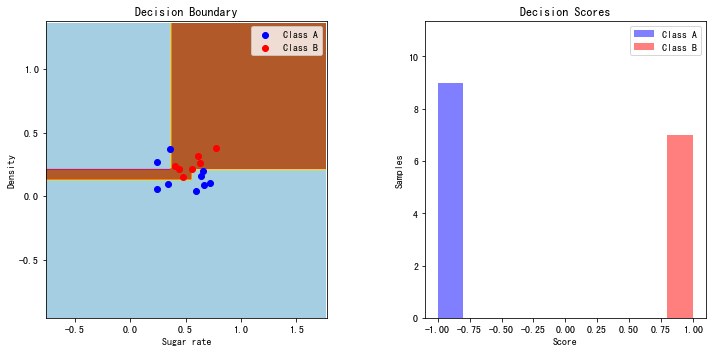

In [99]:
data = np.array(data)
#X = [[float(raw[-7]),float(raw[-6]),float(raw[-5]),float(raw[-4]),float(raw[-3]), float(raw[-2])] for raw in data[1:,1:-1]]

X = [[float(raw[-3]), float(raw[-2])] for raw in data[1:]]
y = [1 if raw[-1]=='是' else 0 for raw in data[1:]]
X = np.array(X)
y = np.array(y)


# Create and fit an AdaBoosted decision tree,不剪枝决策树
bdt = AdaBoostClassifier(DecisionTreeClassifier(),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(X, y)

plot_colors = "br"
plot_step = 0.02
class_names = "AB"

plt.figure(figsize=(10, 5))

# Plot the decision boundaries
plt.subplot(121)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.axis("tight")

# Plot the training points
for i, n, c in zip(range(2), class_names, plot_colors):
    idx = np.where(y == i)
    plt.scatter(X[idx, 0], X[idx, 1],
                c=c, cmap=plt.cm.Paired,
                label="Class %s" % n)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.legend(loc='upper right')
plt.xlabel('Sugar rate')
plt.ylabel('Density')
plt.title('Decision Boundary')

# Plot the two-class decision scores
twoclass_output = bdt.decision_function(X)
plot_range = (twoclass_output.min(), twoclass_output.max())
plt.subplot(122)
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(twoclass_output[y == i],
             bins=10,
             range=plot_range,
             facecolor=c,
             label='Class %s' % n,
             alpha=.5)
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
plt.show()

### 结论
使用不剪枝决策树进行adaboosting分类，最终基分类器趋于相同。仍然可以看到，分类效果非常完美。

# 第二题

西瓜书8.5 Bagging

### Code

Size: 3
Accuracy: 13 / 17



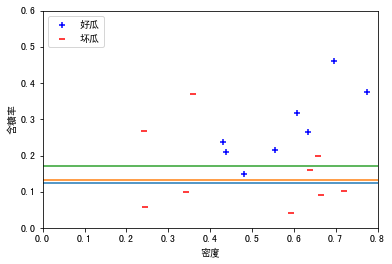

Size: 5
Accuracy: 11 / 17



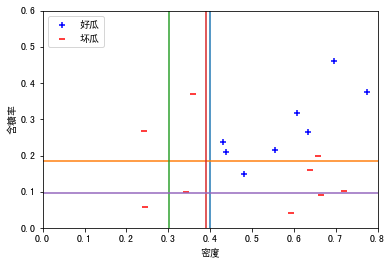

Size: 11
Accuracy: 14 / 17



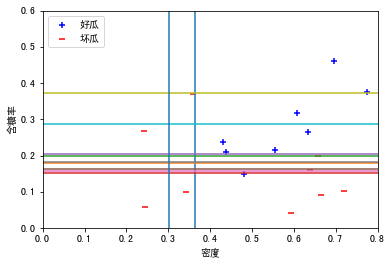

In [105]:
# 单层决策树
class DTStump(object):
    """docstring for DTStump"""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.build()

    # 叶节点选择其类别为D中样本最多的类
    def choose_largest_example(self, X):
        D = self.Y.loc[X.index]
        Count = D.value_counts()
        Max = -1
        for key, value in Count.items():
            if Max < value:
                label = key
                Max = value

        return label

    # 计算给定数据集的熵
    def calc_Ent(self, X):
        D = self.Y.loc[X.index]
        numEntries = D.shape[0]
        Count = D.value_counts()
        Ent = 0.0

        for key, value in Count.items():
            # print(Count[key])
            prob = Count[key] / numEntries
            Ent -= prob * math.log(prob, 2)

        return Ent

    # 生成连续值属性的候选划分点集合T
    def candidate_T(self, key, n):
        L = set(self.X[key])
        T = []
        a, Sum = 0, 0
        for value in L:
            Sum += value
            a += 1
            if a == n:
                T.append(Sum / n)
                a, Sum = 0, 0

        if a > 0:
            T.append(Sum / a)

        return T

    # 计算样本D基于划分点t二分后的连续值属性信息增益
    def calc_Gain_t(self, key, t, Ent_D):
        Ent = 0.0
        D_size = self.X.shape[0]

        Dv = self.X.loc[self.X[key] <= t]
        Dv_size = Dv.shape[0]

        Ent_Dv = self.calc_Ent(Dv)
        Ent += Dv_size / D_size * Ent_Dv

        Dv = self.X.loc[self.X[key] > t]
        Dv_size = Dv.shape[0]

        Ent_Dv = self.calc_Ent(Dv)
        Ent += Dv_size / D_size * Ent_Dv

        return Ent_D - Ent

    # 计算样本D基于不同划分点t二分后的连续值属性信息增益，找出最大增益划分点
    def calc_Gain(self, key, Ent_D):
        n = 2
        T = self.candidate_T(key, n)
        max_Gain, max_partition = -1, -1
        for t in T:
            Gain = self.calc_Gain_t(key, t, Ent_D)
            if max_Gain < Gain:
                max_Gain = Gain
                max_partition = t

        return max_Gain, max_partition

    # 从A中选择最优的划分属性值，返回划分点
    def build(self):
        self.stump = {}
        max_Gain = -1
        for key in self.X.columns:
            Ent_D = self.calc_Ent(self.X)
            Gain, partition = self.calc_Gain(key, Ent_D)

            if max_Gain < Gain:
                best_attr = key
                max_Gain = Gain
                max_partition = partition

        left = self.X.loc[self.X[best_attr] <= partition]
        right = self.X.loc[self.X[best_attr] > partition]

        if left.shape[0] == 0:
            self.stump[0] = self.choose_largest_example(self.X)
        else:
            self.stump[0] = self.choose_largest_example(left)



        if right.shape[0] == 0:
            self.stump[1] = self.choose_largest_example(self.X)
        else:
            self.stump[1] = self.choose_largest_example(right)

        self.attribute, self.partition = best_attr, max_partition
        # print(self.attribute, self.partition, self.stump)

    # 输入测试数据，输出预测标签类
    def predict(self, X):
        value = X[self.attribute]
        if value <= self.partition:
            return self.stump[0]
        else:
            return self.stump[1]


class Bagging(object):
    """docstring for Bagging"""
    def __init__(self, iterate=3):
        self.num = iterate

    # 输入训练集数据和对应标签，训练集成学习器
    def fit(self, X, Y):
        size = X.shape[0]
        weakClassers = []  # 保存每次迭代器的信息
        for _ in range(self.num):
            indexs = [rd.randint(0, size -1) for _ in range(size)]
            # indexs = [a for a in range(size)]

            DX = pd.DataFrame(data=X.loc[indexs]).reset_index(drop=True)
            DY = pd.Series(data=Y.loc[indexs]).reset_index(drop=True)

            weakClasser = DTStump(DX, DY)
            weakClassers.append(weakClasser)  # 保存每一轮的结果信息

        self.weakClassers = weakClassers
        return self

    # 输入测试集，输出集成学习器预测预测的标签类，分类任务使用简单投票法
    def predict(self, X):
        predict_Y = []
        for index, row in X.iterrows():
            vote = {}
            for weakClasser in self.weakClassers:
                label = weakClasser.predict(row)
                if label in vote:
                    vote[label] += 1
                else:
                    vote[label] = 1
            Max = -1
            for label, num in vote.items():
                if Max < num:
                    Max = num
                    vote_label = label

            predict_Y.append(vote_label)

        return predict_Y


# 绘制数据集
def pltDecisionBound(dataSet, clf):
    X1 = np.array(dataSet[dataSet['label'] == 1][['density', 'sugar_rate']])
    X2 = np.array(dataSet[dataSet['label'] == 0][['density', 'sugar_rate']])

    x = np.linspace(0, 0.8, 100)
    y = np.linspace(0, 0.6, 100)
    for weakClasser in clf.weakClassers:
        # print(weakClasser.attribute, weakClasser.partition)
        z = [weakClasser.partition] * 100
        if weakClasser.attribute == 'density':
            plt.plot(z, y)
        else:
            plt.plot(x, z)

    plt.scatter(X1[:, 0], X1[:, 1], marker='+', label='好瓜', color='b')
    plt.scatter(X2[:, 0], X2[:, 1], marker='_', label='坏瓜', color='r')

    plt.xlabel('密度')
    plt.ylabel('含糖率')
    plt.xlim(0, 0.8) # 设置x轴范围
    plt.ylim(0, 0.6) # 设置y轴范围
    plt.rcParams['font.sans-serif' ] =['SimHei']  # 用来正常显示中文标签
    plt.legend(loc='upper left')
    plt.show()


data = [[0.697, 0.460, 1],
        [0.774, 0.376, 1],
        [0.634, 0.264, 1],
        [0.608, 0.318, 1],
        [0.556, 0.215, 1],
        [0.430, 0.237, 1],
        [0.481, 0.149, 1],
        [0.437, 0.211, 1],
        [0.666, 0.091, 0],
        [0.243, 0.267, 0],
        [0.245, 0.057, 0],
        [0.343, 0.099, 0],
        [0.639, 0.161, 0],
        [0.657, 0.198, 0],
        [0.360, 0.370, 0],
        [0.593, 0.042, 0],
        [0.719, 0.103, 0]]
column = ['density', 'sugar_rate', 'label']
dataSet = pd.DataFrame(data, columns=column)


X = dataSet[['density', 'sugar_rate']]
y = dataSet['label']

sizes = [3, 5, 11]
for size in sizes:
    clf = Bagging(size)
    clf = clf.fit(X, y)
    predict_Y = clf.predict(X)

    accuracy = 0
    for y1, y2 in zip(y, predict_Y):
        if y1 == y2:
            accuracy += 1

    print('Size:', size)
    print('Accuracy:', accuracy, '/', y.shape[0])
    print('')

    pltDecisionBound(dataSet, clf)


## 参考二 2019202359 程杰翰

# Question1 

以不剪枝决策树为学习器，实现AdaBoost集成。

参考代码：https://blog.csdn.net/qq_41224398/article/details/103241188?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522162193115816780264081248%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=162193115816780264081248&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_v2~rank_v29-1-103241188.pc_search_result_cache&utm_term=AdaBoost%E4%B8%8D%E5%89%AA%E6%9E%9D%E5%86%B3%E7%AD%96%E6%A0%91%E4%B8%BA%E5%9F%BA%E5%AD%A6%E4%B9%A0%E5%99%A8&spm=1018.2226.3001.4187

集成学习器（字典）： ZiDian3 = {0: {'weight': 0.7702225204735745, 'stump': {'feature': 1, 'threshVal': 0.19875, 'Class': 1, 'error': 0.1764705882352941}}, 1: {'weight': 0.47778539705010437, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.277765871485025}}, 2: {'weight': 0.5547540355729378, 'stump': {'feature': 0, 'threshVal': 0.7408125000000001, 'Class': 1, 'error': 0.2479626106793391}}}
准确率为： 0.8235294117647058


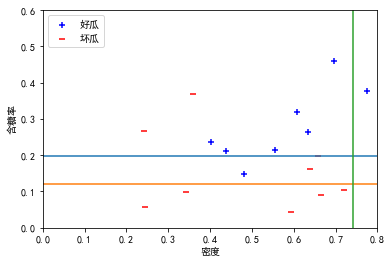

集成学习器（字典）： ZiDian5 = {0: {'weight': 0.7702225204735745, 'stump': {'feature': 1, 'threshVal': 0.19875, 'Class': 1, 'error': 0.1764705882352941}}, 1: {'weight': 0.47778539705010437, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.277765871485025}}, 2: {'weight': 0.5547540355729378, 'stump': {'feature': 0, 'threshVal': 0.7408125000000001, 'Class': 1, 'error': 0.2479626106793391}}, 3: {'weight': 0.4824264950353837, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.27590759828682543}}, 4: {'weight': 0.5521981173695141, 'stump': {'feature': 1, 'threshVal': 0.381625, 'Class': 1, 'error': 0.2489170790198443}}}
准确率为： 0.8235294117647058


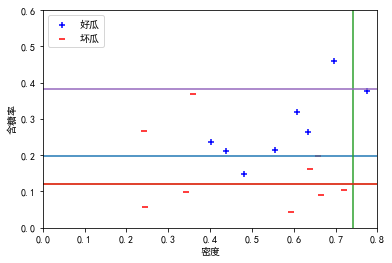

集成学习器（字典）： ZiDian11 = {0: {'weight': 0.7702225204735745, 'stump': {'feature': 1, 'threshVal': 0.19875, 'Class': 1, 'error': 0.1764705882352941}}, 1: {'weight': 0.47778539705010437, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.277765871485025}}, 2: {'weight': 0.5547540355729378, 'stump': {'feature': 0, 'threshVal': 0.7408125000000001, 'Class': 1, 'error': 0.2479626106793391}}, 3: {'weight': 0.4824264950353837, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.27590759828682543}}, 4: {'weight': 0.5521981173695141, 'stump': {'feature': 1, 'threshVal': 0.381625, 'Class': 1, 'error': 0.2489170790198443}}, 5: {'weight': 0.484274050419906, 'stump': {'feature': 1, 'threshVal': 0.12037500000000001, 'Class': 1, 'error': 0.27516999107889073}}, 6: {'weight': 0.5074232304334928, 'stump': {'feature': 1, 'threshVal': 0.381625, 'Class': 1, 'error': 0.26603246232838373}}, 7: {'weight': 0.4849256842573034, 'stump': {'feature': 1, 'thresh

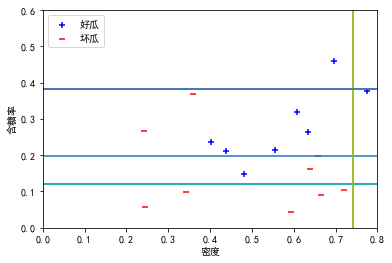

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linspace
data = np.array([
    [0.697, 0.460, 1],
    [0.774, 0.376, 1],
    [0.634, 0.264, 1],
    [0.608, 0.318, 1],
    [0.556, 0.215, 1],
    [0.403, 0.237, 1],
    [0.481, 0.149, 1],
    [0.437, 0.211, 1],
    [0.666, 0.091, 0],
    [0.243, 0.267, 0],
    [0.245, 0.057, 0],
    [0.343, 0.099, 0],
    [0.639, 0.161, 0],
    [0.657, 0.198, 0],
    [0.360, 0.370, 0],
    [0.593, 0.042, 0],
    [0.719, 0.103, 0]
])

def ErrRate(data,feature,threshVal,Class,weight):
    weight_flt = weight.flatten()
    errorCount = 0
    Count = 0
    if Class == -1:#低于阈值认为好瓜
        for d in data:
            if (d[feature] - threshVal <= 0 and d[2] == 0) or (d[feature] - threshVal>0 and d[2] == 1):#判断错误
                errorCount += weight_flt[Count]
            Count += 1
    else:
        for d in data:
            if (d[feature] >= threshVal and d[2] == 0) or (d[feature] < threshVal and d[2] == 1):#判断错误
                errorCount += weight_flt[Count]
            Count += 1
    return errorCount

def Stump(data,weight):#建立决策树桩
    bestError = np.inf
    bestStump = {}
    steps = 16
    for i in range(data.shape[1]-1):
        Min = data[:,i].min()
        Max = data[:,i].max()
        lenth = (Max - Min)/steps
        for j in range(data.shape[0]):
            threVal = Min + j * lenth
            for Class in [-1,1]:
                error = ErrRate(data,i,threVal,Class,weight)
                if error < bestError:
                    bestError = error
                    bestStump["feature"] = i
                    bestStump["threshVal"] = threVal
                    bestStump["Class"] = Class
                    bestStump["error"] = error
    return bestStump# 返回决策树信息

def pre(data,bestStump):
    if bestStump["Class"] == -1:
        if data[bestStump["feature"]] <= bestStump["threshVal"]:
            return 1
        else:
            return -1
    else:
        if data[bestStump["feature"]] >= bestStump["threshVal"]:
            return 1
        else:
            return -1
    
def AdaBoost(data, times):#times为迭代次数
    n,m = data.shape
    weight = np.ones([1,n])/n
    Class = data[:,2].reshape(1,-1)
    ZiDian = {}#保存字典
    for t in range(times):
        stump = Stump(data,weight)
        error = stump["error"]
        wt = np.log((1 - error)/error)/2 #权重
        Pre = np.zeros([1,n])
        for i in range(n):
            Pre[0][i] = pre(data[i],stump)
        a = np.exp(-wt * Class * Pre)
        weight = weight * a / np.dot(weight,a.T)
        
        ZiDian[t] = {}
        ZiDian[t]["weight"] = wt
        ZiDian[t]["stump"] = stump
    return ZiDian

def AdaPre(data,ZiDian):#通过总分类器进行分类
    score = 0
    for key in ZiDian.keys():
        Pre = pre(data,ZiDian[key]["stump"])
        score += ZiDian[key]["weight"] * Pre
    if score > 0:
        return 1
    else:
        return 0

def calAcc(data, weight):
    right = 0
    for d in data:
        Pre = AdaPre(d,weight)
        if Pre == d[-1]:
            right += 1
    return right / data.shape[0]

def draw(data, clf):
    X1, X2 = [], []
    Y1, Y2 = [], []
    datas=data
    labels=data[:,2]
    #print(np.argwhere(data==1))
    for data, label in zip(datas, labels):
        if label > 0:
            X1.append(data[0])
            Y1.append(data[1])
        else:
            X2.append(data[0])
            Y2.append(data[1])

    x = linspace(0, 0.8, 100)
    y = linspace(0, 0.6, 100)

    for key in clf.keys():
        z = [clf[key]["stump"]["threshVal"]]*100
        if clf[key]["stump"]["feature"] == 0:
            plt.plot(z, y)
        else:
            plt.plot(x, z)

    plt.scatter(X1, Y1, marker='+', label='好瓜', color='b' )
    plt.scatter(X2, Y2, marker='_', label='坏瓜', color='r')

    #设置坐标轴
    plt.xlabel('密度')
    plt.ylabel('含糖率')
    plt.xlim(0, 0.8)  
    plt.ylim(0, 0.6)  
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.legend(loc='upper left')
    plt.show()
    
for t in [3,5,11]:
    ZiDian = AdaBoost(data,t)
    print('集成学习器（字典）：',f"ZiDian{t} = {ZiDian}")
    print('准确率为：',calAcc(data, ZiDian))
    draw(data,ZiDian)

# Question 2

实现bagging集成，与图8.6比较

参考代码https://blog.csdn.net/River_J777/article/details/108500329?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522162193115816780264081248%2522%252C%2522scm%2522%253A%252220140713.130102334.pc%255Fall.%2522%257D&request_id=162193115816780264081248&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~first_rank_v2~rank_v29-7-108500329.pc_search_result_cache&utm_term=AdaBoost%E4%B8%8D%E5%89%AA%E6%9E%9D%E5%86%B3%E7%AD%96%E6%A0%91%E4%B8%BA%E5%9F%BA%E5%AD%A6%E4%B9%A0%E5%99%A8&spm=1018.2226.3001.4187

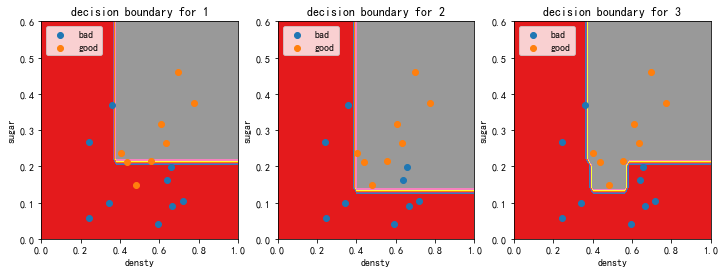

In [2]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

clf1 = BaggingClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=3) 
clf2 = BaggingClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=5)
clf3 = BaggingClassifier(DecisionTreeClassifier(max_depth=2),n_estimators=11)
x = data[:,[0,1]]
y = data[:,2]
for clf in [clf1,clf2,clf3]:
    clf.fit(x,y)
    
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xset, yset = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
label_set = []
for clf in [clf1,clf2,clf3]:
    out_label = clf.predict(np.c_[xset.ravel(), yset.ravel()])
    out_label = out_label.reshape(xset.shape)
    label_set.append(out_label)

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(12, 4))
(ax0,ax1,ax2) = axes.flatten()
for k,ax in enumerate((ax0,ax1,ax2)):
    ax.contourf(xset,yset,label_set[k],cmap=plt.cm.Set1)
    for i, n in zip([0,1], ['bad','good']):
        idx = np.where(y == i)
        ax.scatter(x[idx, 0], x[idx, 1], label=n)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.6)
    ax.legend(loc='upper left')
    ax.set_ylabel('sugar')
    ax.set_xlabel('densty')
    ax.set_title('decision boundary for %s' % (k+1))
plt.show()


## 参考三 2019202091-徐克丰

# 第三题
## 题目描述
在MINST手写体数据集中，调包使用随机森林区分3和6，并比较与单棵树的效果。
## 代码实现

In [ ]:
#首先导入期中时的数据读取与变量选择
import copy #用于列表的深拷贝
import struct  #用于解包，即读出数据
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier #调用随机森林算法
from sklearn.tree import DecisionTreeClassifier #调用决策树算法

#读入60000个训练集和10000个测试集的手写字体数据集合
def load_dataset(kind='train'):
    #设定打开路径，数据文件与执行代码在同一文件夹下，直接用文件名
    labels_path = kind+'-labels.idx1-ubyte' 
    images_path = kind+'-images.idx3-ubyte'
    #打开文件，读取数据标签和图片的具体数据
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8)) #前8个存储空间有两个32 bit intger,偏移值为8
        labels = np.fromfile(lbpath,dtype=np.uint8) #文件指针lbpath移动到了0008，读取标签(手写数字值)，即0，1，2...9
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16)) #前16个存储空间包含了其他信息，为4个32 bit intger
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)#每一行为一张图片的784个像素数据
    return images, labels  #返回训练集/测试集的图片数据和分类标签

#处理图片数据，选择每张图片对角线的k-2个，外加两个波动坐标(12,17),(17,11)，返回处理后的训练集合
def heapqsort(train_images,test_images,train_labels,test_labels,k=10):      
    u1=np.array([9,10,11,12,13,14,15,16,17,18])
    u2=np.array([9,10,11,17,13,14,15,16,11,18]) 
    X_train=np.array(train_images[0].reshape(28,28)[u1,u2]).reshape(1,k)
    X_test=np.array(test_images[0].reshape(28,28)[u1,u2]).reshape(1,k)
    for i in range(len(train_images)):
        headk=np.array(train_images[i].reshape(28,28)[u1,u2].reshape(1,k))
        if i>=1:
            X_train=np.r_[X_train,headk]  #对每张图片主对角线上的灰度值，并入新的数组
    for i in range(len(test_images)):
        headk=np.array(test_images[i].reshape(28,28)[u1,u2].reshape(1,k))
        if i>=1:
            X_test=np.r_[X_test,headk]  #对每张图片主对角线上的灰度值，并入新的数组
    return X_train,X_test

#读入测试数据和训练数据，储存到numpy数组中
train_images,train_labels=load_dataset('train')
test_images,test_labels=load_dataset('t10k')

#处理图像数据，选择每张图片对角线的k-2个，外加两个波动坐标(12,17),(17,11)
X_train,X_test=heapqsort(train_images,test_images,train_labels,test_labels,k=10)
y_train=train_labels
y_test=test_labels

In [ ]:
#提取相关的训练集和测试集
X_train6=X_train[y_train==6];X_train3=X_train[y_train==3]
y_train6=y_train[y_train==6];y_train3=y_train[y_train==3]
X_test6=X_test[y_test==6];X_test3=X_test[y_test==3]
y_test6=y_test[y_test==6];y_test3=y_test[y_test==3]
X_train63=np.r_[X_train6,X_train3]
X_test63=np.r_[X_test6,X_test3]
y_train63=np.r_[y_train6,y_train3]
y_test63=np.r_[y_test6,y_test3]

#调包，使用随机森林算法
rf=RandomForestClassifier() 
rf.fit(X_train63,y_train63)
print('采用随机森林算法在测试集上进行测试得到的分类精度为：%.6f'%(rf.score(X_test63,y_test63)))
#调包，使用决策树算法
stree=DecisionTreeClassifier()
stree.fit(X_train63,y_train63)
print('采用单棵决策树在测试集上进行测试得到的分类精度为  ：%.6f'%(stree.score(X_test63,y_test63)))

## 结果分析
与期中作业采用相同的变量选取方式，用训练集进行训练，用测试集评估模型性能。采用随机森林算法得到的分类精度为0.945，采用单棵决策树得到的分类精度为0.902。可以发现随机森林算法的泛化性能要优于单棵决策树的泛化性能。这是因为随机森林中的基学习器的多样性不仅来自样本扰动，还来自属性扰动，这就使得最终集成的泛化性能可通过个体学习器之间的差异度增加而进一步提升。